#  TITLE TUTORIAL - date 

Pedro Di Nezio (pdn@utig.ig.utexas.edu)



The latest version of this [IPython notebook](http://ipython.org/notebook.html) tutorial is available at
<font color='blue'>Github adress</font>.



## Introduction

Understand how to use a Heat budget to compare ENSO. Example bar for 0ka and 21ka and then study of feedback directly using the NDO.


This is the introduction, we are going to bla balabalala la
* first we gonna 
    * then a second point ert 
    
Every body is _happy_, we __goonna rock__ that shit 


http://nbviewer.jupyter.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
from collections import defaultdict
import matplotlib.dates as mdates
from datetime import datetime,timedelta
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from spectrum import *
from scipy.stats import skewnorm
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.reset_orig()
%matplotlib inline 

from scipy.stats import skew
from scipy import stats

from scipy.optimize import fsolve
from functions.composite import composite 

from IPython.display import HTML

In [3]:
CASE='0ka' # or 0ka, 12ka, 2xco2, 15ka etc. 

In [4]:
heat_budget=np.load('Heat_budget_'+CASE+'.npy').item()

In [5]:
# definition of the exponential functions for the fits and initial guess for the constants 

def exp_f(x, a, b, c):
    return a*np.exp(-b*x)+c

def exp_f2(x, a, b, c,d,e):
    return a*np.exp(-b*x[0])+c*np.exp(-d*x[1])+e

if CASE == '0ka':
    cst_quc=[ [1e-3,1e-3,1e-3] , [1e-3,1e-3,1e-6] , [-10,-1e2,-1e4], [-1e2,-1e2,-1e2]]
    cst_qut=[ [1e-4,1e-3,1e6 ] , [1e-3,1e-6,1e-6] , [-10,-1  ,-10 ], [1e2 ,-1  ,-1  ]]
    cin     = [ cst_quc, 1, -1, 1, 1, 1, 10,cst_qut,-1,-1,1,1]
    lag=6
    N0,ska,skl=0.17,1,-0.56
elif CASE == '12ka':
    cst_quc=[ [1e-3,1e-3,1e-3] , [1e-3,1e-3,1e-6] , [-10,-1e2,-1e4], [-1e2,-1e2,-1e2]]
    cst_qut=[ [1e-4,1e-3,1e6 ] , [1e-3,1e-6,1e-6] , [-10,-1  ,-10 ], [1e2,-1  ,-1   ]]
    cin     = [ cst_quc, 0.4, -1, 1, 1, 1, 10,cst_qut,-1,-1,1,1]
    lag=6
    N0,ska,skl=0.145,1,-0.56
elif CASE == '15ka':
    cst_quc=[ [1e-3,100,1e-3]  , [1e-3,1e-3,1e-6] ,[-1e4,-1e4,-1e4], [-1e2,-1e2,-1e2]]
    cst_qut=[ [1e4 ,1e4,1e4 ]  , [1e-3,1e-6,1e-6] ,[-1  ,-1  ,-1  ], [1e2 ,-1  ,-1  ]]
    cin     = [ cst_quc, 1, -100, 1, 1, 1, 10,cst_qut,-1,-10,1,1]
    lag=6
    N0,ska,skl=0.12,1,-0.56
elif CASE == '21ka':    
    cst_quc=[ [1e-3,1e-2,1e-2] , [1e-2,1e-3,1e-6] ,[-1e2,-1e4,-1e4], [-1e2,-1e2,-1e2]]
    cst_qut=[ [1e4,1e4,1e4]    , [1e-3,1e-3,1e-6] ,[-1e-1,-1e-1,-1e-1],  [100,100,-1]]
    cin     = [ cst_quc, 1, -100, 1, 1, 1, 10,cst_qut,-1,-1,1,1]
    lag=6
    N0,ska,skl=0.134,0,0
elif CASE == '24ka':    
    cst_quc=[ [1e-3,1e-2,1e-2] , [1e-2,1e-3,1e-6] ,[-1e2,-1e4,-1e4], [-1e2,-1e2,-1e2]]
    cst_qut=[ [1e4,1e4,1e4]    , [1e-3,1e-3,1e-6] ,[-1e-1,-1e-1,-1e-1],  [100,100,-1]]
    cin     = [ cst_quc, 1e-3, -1, 1, 1, 0, 100,cst_qut,-100,-1,1,1]
    lag=6
    N0,ska,skl=0.135,0,0
elif CASE =='2xco2':
    cst_quc=[ [1e-3,1e-3,1e-3] , [1e-3,1e-3,1e-6] , [-10,-1e2,-1e4], [-1e2,-1e2,-1e2]]
    cst_qut=[ [1e-4,1e-3,1e2 ] , [1e-3,1e-6,1e-6] , [-10,-1  ,-1e2], [1e2 ,-1  ,-1  ]]
    cin     = [ cst_quc, 1, -1, 1, 1, 1, 10,cst_qut,-1e-1,-1,1,1]
    lag=6
    N0,ska,skl=0.18,1,-0.56

## Computation of the exponential fit coefficients

ENSO can be reduced to a simple conceptual model, such as the Non-linear Delayed Oscillator (NDO). Changes in SST anomalies in the Niño3.4 region can be expressed as follow: 

$\frac{\partial T'}{\partial t} = aT'(t) -bT'(t-t_0)-cT'(t)-dT'(t)+N(t)$

In [6]:
Q=defaultdict(dict) # Dictionnary to stock the fit coefficients 
R=defaultdict(dict)

var_name   = ['qu','qv','qw','qnet','qres']
proc1      = ['_curr','_temp','_nl']
proc2      = ['']

var_t=['tos','tos']

month_ind=np.roll(np.linspace(0,11,12),1)
inc=0 
for vname in var_name:
    
    if vname == 'qnet' or vname == 'qres':
        proc=proc2
        if vname == 'qnet':
            varT=var_t[0]
        else: 
            varT=var_t[1]
    else:
        proc=proc1
        varT=var_t[1]

    for pr in proc: 

        varname=vname+pr 
        coef=np.zeros((12,3))
        coef_r=np.zeros((12))
        print(varname,end=',')
        
        nyr=int(len(heat_budget[varT]))
        var1=np.reshape(heat_budget[varT],(int(nyr/12),12))
        var2=np.reshape(heat_budget[varname],(int(nyr/12),12))
        
        if not (varname == 'qw_temp' or varname == 'qu_curr'):


            for month in range(12):
                
                monthi=[int(i) for i in np.roll(month_ind,-month)[1:2]]
                
                xdata=[]
                xdata=np.reshape(var1[:,monthi],(int(nyr/12*1)))
                ydata=np.reshape(var2[:,monthi],(int(nyr/12*1)))
        
                # Exponential fit 
                try: 
                    popt, pcov = curve_fit(exp_f, xdata, ydata, p0=(cin[inc], 1e-3, cin[-1]))
                except RuntimeError:
                    popt, pcov = curve_fit(exp_f, xdata, ydata, p0=(-cin[inc], 1e-3, cin[-1]))

                # Computation R**2 of the fit 
                residuals = ydata- exp_f(xdata, *popt)
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((ydata-np.mean(ydata))**2)
                r_squared = 1 - (ss_res / ss_tot)

                if np.sqrt(r_squared) < 0.1:
                    popt=popt*0
                    
                coef_r[month]=np.sqrt(r_squared)
                coef[month,:]=popt
            R[varname]=coef_r
            Q[varname]=coef 

            #delayed feedback 
        else: 
            coef=np.zeros((12,5))
            for month in range(12): 
                monthi=[int(i) for i in np.roll(month_ind,-month)[1:2]]
                monthi_lag=[int(i) for i in np.roll(month_ind,-month-lag)[1:2]]
                    
                if month-lag < 0:  
                    xdata2=np.reshape(var1[0:-1,monthi_lag],(int(nyr/12*1-1)))
                    xdata1=np.reshape(var1[1::,monthi],(int(nyr/12*1-1)))
                    ydata=np.reshape(var2[1::,monthi],(int(nyr/12*1-1)))
                else: 
                    xdata2=np.reshape(var1[0::,monthi_lag],(int(nyr/12*1)))
                    xdata1=np.reshape(var1[0::,monthi],(int(nyr/12*1)))
                    ydata=np.reshape(var2[0::,monthi],(int(nyr/12*1))) 

                if varname=='qu_curr':
                    if month ==4: 
                        cin[inc][3][0]=100
                    else:
                        cin[inc][3][0]=-100

                xdata=np.stack((xdata1,xdata2),axis=0)

                try: 
                    popt, pcov = curve_fit(exp_f2, xdata, ydata, p0=(cin[inc][0][0],cin[inc][1][0], cin[inc][2][0],1e-8,cin[inc][3][0]))
                except RuntimeError: 
                    try:
                        popt, pcov = curve_fit(exp_f2, xdata, ydata, p0=(cin[inc][0][1],cin[inc][1][1], cin[inc][2][1],1e-8,cin[inc][3][1]))
                    except RuntimeError:
                        popt, pcov = curve_fit(exp_f2, xdata, ydata, p0=(cin[inc][0][2],cin[inc][1][2], cin[inc][2][2],1e-8,cin[inc][3][2]))

                    
                residuals = ydata- exp_f2(xdata, *popt)
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((ydata-np.mean(ydata))**2)
                r_squared = 1 - (ss_res / ss_tot)

                if varname=='qw_temp':
                    if month ==0 or month == 1 or month == 2 or month == 3: 
                        popt[0]=popt[0]/1
                
                if varname=='qu_curr':
                    if month == 1 or month == 2 or month == 3: 
                        popt[2]=popt[2]/1
                        popt[0]=popt[0]/1
                        
                if np.sqrt(r_squared) < 0.1:
                    popt=popt*0
                 
                coef_r[month]=np.sqrt(r_squared)
                coef[month,:]=popt

            R[varname]=coef_r        
            Q[varname]=coef 
        inc=inc+1

qu_curr,qu_temp,qu_nl,qv_curr,qv_temp,qv_nl,qw_curr,qw_temp,qw_nl,qnet,qres,

# PLot fits 

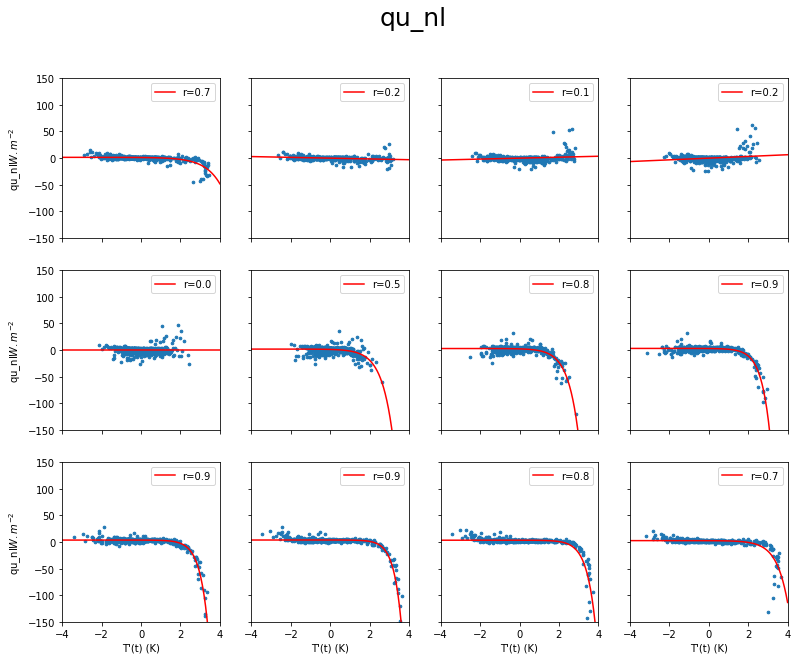

In [7]:
var_plot='qu_nl'

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)

inc=0
for i in range(3):
    for j in range(4):
    
        xdata=np.reshape(heat_budget['tos'],(int(nyr/12),12))[:,inc]
        ydata=np.reshape(heat_budget[var_plot],(int(nyr/12),12))[:,inc]
        
        xx = np.linspace(-4,4,100)
        yy = exp_f(xx, *Q[var_plot][inc,:])
        
        axes[i][j].scatter(xdata,ydata,s=7)
        axes[i][j].plot(xx,yy,color='r',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

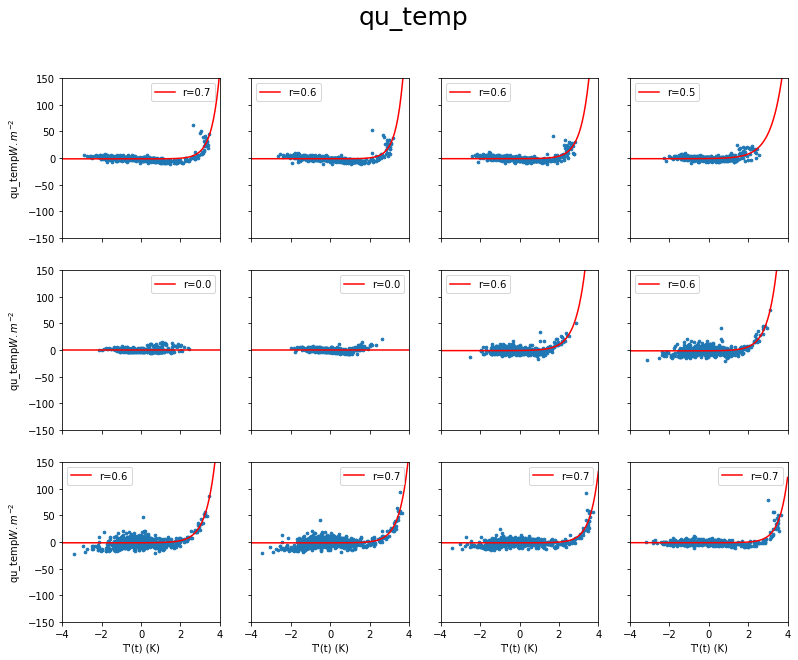

In [8]:
var_plot='qu_temp'

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)

inc=0
for i in range(3):
    for j in range(4):
    
        xdata=np.reshape(heat_budget['tos'],(int(nyr/12),12))[:,inc]
        ydata=np.reshape(heat_budget[var_plot],(int(nyr/12),12))[:,inc]
        
        xx = np.linspace(-4,4,100)
        yy = exp_f(xx, *Q[var_plot][inc,:])
        
        axes[i][j].scatter(xdata,ydata,s=7)
        axes[i][j].plot(xx,yy,color='r',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

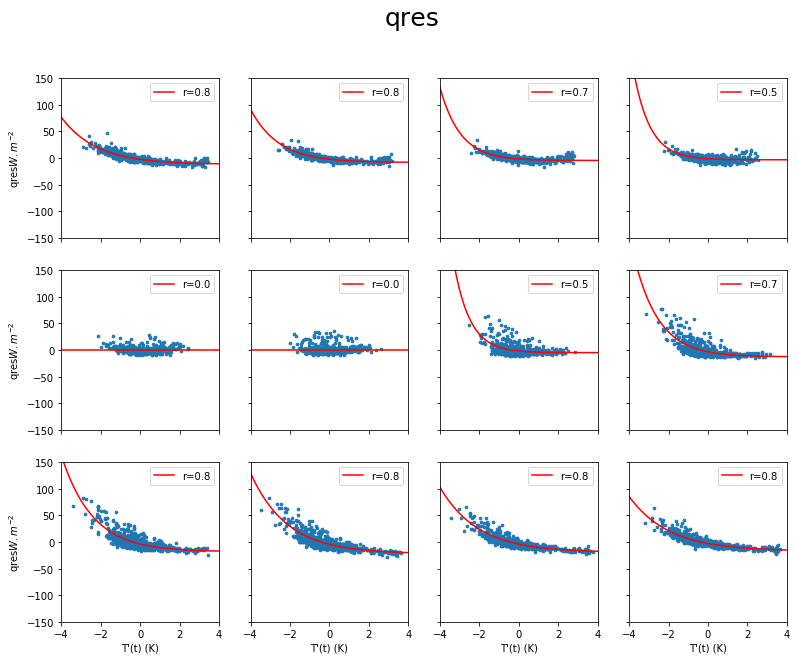

In [9]:
var_plot='qres'

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)

inc=0
for i in range(3):
    for j in range(4):
    
        xdata=np.reshape(heat_budget['tos'],(int(nyr/12),12))[:,inc]
        ydata=np.reshape(heat_budget[var_plot],(int(nyr/12),12))[:,inc]
        
        xx = np.linspace(-4,4,100)
        yy = exp_f(xx, *Q[var_plot][inc,:])
        
        axes[i][j].scatter(xdata,ydata,s=7)
        axes[i][j].plot(xx,yy,color='r',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

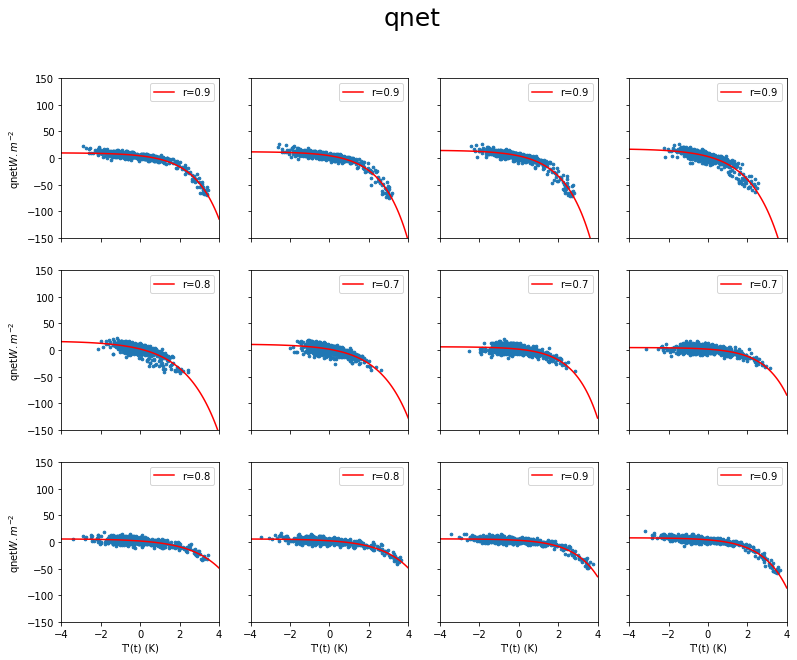

In [10]:
var_plot='qnet'

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)

inc=0
for i in range(3):
    for j in range(4):
    
        xdata=np.reshape(heat_budget['tos'],(int(nyr/12),12))[:,inc]
        ydata=np.reshape(heat_budget[var_plot],(int(nyr/12),12))[:,inc]
        
        xx = np.linspace(-4,4,100)
        yy = exp_f(xx, *Q[var_plot][inc,:])
        
        axes[i][j].scatter(xdata,ydata,s=7)
        axes[i][j].plot(xx,yy,color='r',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

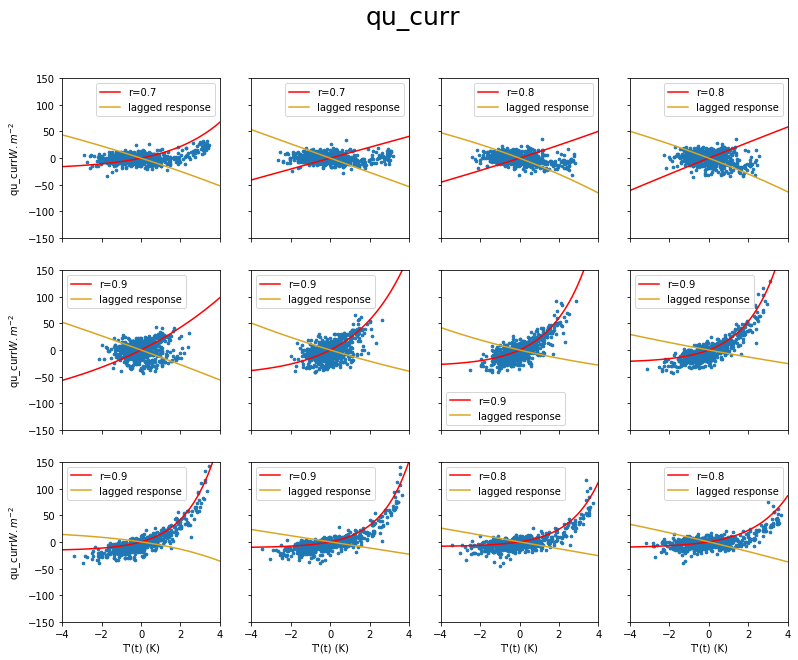

In [11]:
var_plot='qu_curr'

var1=np.reshape(heat_budget['tos'],(int(nyr/12),12))
var2=np.reshape(heat_budget[var_plot],(int(nyr/12),12))

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)
inc=0
for i in range(3):
    for j in range(4):
        

        
        monthi=[int(k) for k in np.roll(month_ind,-inc)[1:2]]
        monthi_lag=[int(k) for k in np.roll(month_ind,-inc-lag)[1:2]]
        if inc-lag < 0:  
            xdata2=np.reshape(var1[0:-1,monthi_lag],(int(nyr/12*1-1)))
            xdata1=np.reshape(var1[1::,monthi],(int(nyr/12*1-1)))
            ydata=np.reshape(var2[1::,monthi],(int(nyr/12*1-1)))
        else: 
            xdata2=np.reshape(var1[0::,monthi_lag],(int(nyr/12*1)))
            xdata1=np.reshape(var1[0::,monthi],(int(nyr/12*1)))
            ydata=np.reshape(var2[0::,monthi],(int(nyr/12*1))) 
                    
        xdata=np.stack((xdata1,xdata2),axis=0)
            
        xx1 = np.linspace(-4,4,81)
        yy1 = exp_f(xx1, Q[var_plot][inc,0],Q[var_plot][inc,1],0) - exp_f(0, Q[var_plot][inc,0],Q[var_plot][inc,1],0)
        
        xx2 = xx1
        yy2 = exp_f(xx2, Q[var_plot][inc,2],Q[var_plot][inc,3],0) - exp_f(0, Q[var_plot][inc,2],Q[var_plot][inc,3],0)
        
        axes[i][j].scatter(xdata1,ydata,s=7)
        axes[i][j].plot(xx1,yy1,color='red',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].plot(xx2,yy2,color='goldenrod',label='lagged response')
        
        
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

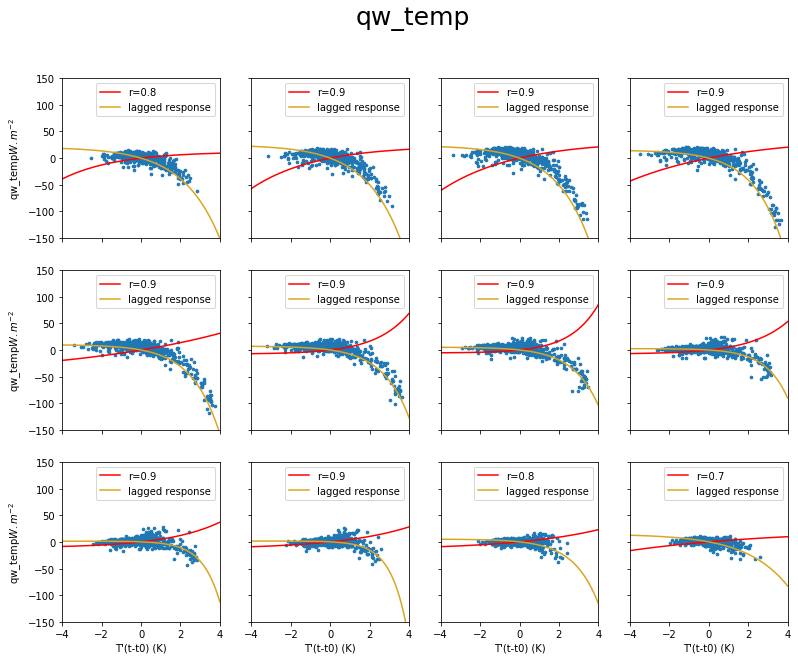

In [12]:
var_plot='qw_temp'

var1=np.reshape(heat_budget['tos'],(int(nyr/12),12))
var2=np.reshape(heat_budget[var_plot],(int(nyr/12),12))

fig, axes = plt.subplots(3,4,figsize=[13,10],sharex=True,sharey=True)
inc=0
for i in range(3):
    for j in range(4):
        monthi=[int(k) for k in np.roll(month_ind,-inc)[1:2]]
        monthi_lag=[int(k) for k in np.roll(month_ind,-inc-lag)[1:2]]
        if inc-lag < 0:  
            xdata2=np.reshape(var1[0:-1,monthi_lag],(int(nyr/12*1-1)))
            xdata1=np.reshape(var1[1::,monthi],(int(nyr/12*1-1)))
            ydata=np.reshape(var2[1::,monthi],(int(nyr/12*1-1)))
        else: 
            xdata2=np.reshape(var1[0::,monthi_lag],(int(nyr/12*1)))
            xdata1=np.reshape(var1[0::,monthi],(int(nyr/12*1)))
            ydata=np.reshape(var2[0::,monthi],(int(nyr/12*1))) 
                    
        xdata=np.stack((xdata1,xdata2),axis=0)
            
        xx1 = np.linspace(-4,4,81)
        yy1 = exp_f(xx1, Q[var_plot][inc,0],Q[var_plot][inc,1],0) - exp_f(0, Q[var_plot][inc,0],Q[var_plot][inc,1],0)
        
        xx2 = xx1
        yy2 = exp_f(xx2, Q[var_plot][inc,2],Q[var_plot][inc,3],0) - exp_f(0, Q[var_plot][inc,2],Q[var_plot][inc,3],0)
        
        axes[i][j].scatter(xdata2,ydata,s=7)
        axes[i][j].plot(xx1,yy1,color='red',label='r='+str(R[var_plot][inc])[0:3])
        axes[i][j].plot(xx2,yy2,color='goldenrod',label='lagged response')
        
        
        axes[i][j].legend()
        inc=inc+1
        axes[i][j].set_ylim(-150,150)
        axes[i][j].set_xlim(-4,4)
        if j == 0 :
            axes[i][j].set_ylabel(var_plot+r'$W.m^{-2}$')

        if i == 2 :
            axes[i][j].set_xlabel("T'(t-t0) (K)")
               
plt.suptitle(var_plot,fontsize=25)
plt.show()

In [13]:
NN=960/2
Temp=np.linspace(-3,3,NN-1)

var_name   = ['qu','qv','qw','qnet','qres']
proc1      = ['_curr','_temp','_nl']
proc2      = ['']

inc=0 
for vname in var_name:
    
    if vname == 'qnet' or vname == 'qres':
        proc=proc2
    else:
        proc=proc1

    for pr in proc: 

        varname=vname+pr 
        coef=np.zeros((12,3))
        
        if not (varname == 'qw_temp' or varname == 'qu_curr'):

            Q[varname+'f'] = [ exp_f(Temp, *Q[varname][j,:]) - exp_f(Temp, *Q[varname][j,:])[int(NN/2)-1] for j in range(12)]
            Q[varname+'f'] =  Q[varname+'f']/ (1000 * 4000. * (heat_budget['mld']+10)) *(365*24*60*60)
        else: 
            Q[varname+'f1'] = [ exp_f(Temp, Q[varname][j,0],Q[varname][j,1],0) - exp_f(Temp, Q[varname][j,0],Q[varname][j,1],0)[int(NN/2)-1] for j in range(12)]
            Q[varname+'f1'] =  Q[varname+'f1']/ (1000 * 4000. * (heat_budget['mld']+10)) *(365*24*60*60)

            Q[varname+'f2'] = [ exp_f(Temp, Q[varname][j,2],Q[varname][j,3],0) - exp_f(Temp, Q[varname][j,2],Q[varname][j,3],0)[int(NN/2)-1] for j in range(12)]
            Q[varname+'f2'] =  Q[varname+'f2']/ (1000 * 4000. * (heat_budget['mld']+10)) *(365*24*60*60)

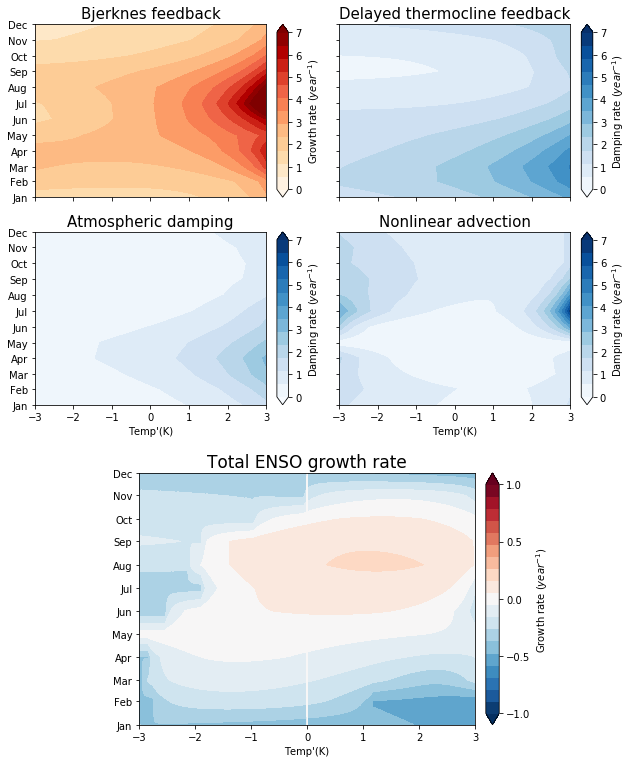

In [14]:
# Computation of the different feedbacks
Bjerknes_f  =  (Q['qu_currf1']+Q['qw_tempf1']+Q['qv_currf']+Q['qv_tempf']+Q['qu_tempf']+Q['qw_currf']) /Temp
atm_damping = -(Q['qnetf']) /Temp
nl_damping  = -(Q['qu_nlf']+Q['qv_nlf']+Q['qw_nlf']+Q['qresf']) /Temp  
del_damping = -(Q['qw_tempf2']+Q['qu_currf2']) /Temp    
# growth_tot  = Bjerknes_f - atm_damping - nl_damping

growth_tot=np.zeros((12,len(Temp)))
for mo in range(12):
    for T in range(len(Temp)): 
        func = lambda sig : sig - del_damping[mo,T] * np.exp(- sig * (-lag)) - atm_damping[mo,T] - nl_damping[mo,T]+ Bjerknes_f[mo,T]
        growth_tot[mo,T] = fsolve(func, 0)
        
# Set up Y-axis time
years = [datetime(2018, i+1, 1) for i in range(12)]
name_feed=['Bjerknes_f','del_damping','atm_damping','nl_damping']
subtitle =['Bjerknes feedback','Delayed thermocline feedback',\
          'Atmospheric damping','Nonlinear advection']
cb_label=[r'Growth rate ($year^{-1}$)',r'Damping rate ($year^{-1}$)',r'Damping rate ($year^{-1}$)',r'Damping rate ($year^{-1}$)']
cmaps    =['OrRd','Blues','Blues','Blues']

p, ncol, nrow, vmin, vmax, Nlev, fmt={}, 2, 2, 0, 7, 13, mdates.DateFormatter('%b')


fig, axs = plt.subplots(nrow, ncol, figsize=(10,7), sharey=True, sharex=True)

inc=0
for i in range(nrow):
    for j in range(ncol):
        p[inc] = axs[i][j].contourf(Temp,years,eval(name_feed[inc]),levels=np.linspace(vmin, vmax, Nlev)\
                                    ,cmap=cmaps[inc],extend='both')
        
        divider = make_axes_locatable(axs[i][j])
        cax = divider.append_axes("right", size="5%", pad=0.15)
        plt.colorbar(p[inc],cax=cax,ticks=mticker.MultipleLocator(1),label=cb_label[inc])
        axs[i][j].set_title(subtitle[inc],fontsize=15)
        axs[i][j].yaxis.set_major_formatter(fmt)
        
        if i ==1 :
            axs[i][j].set_xlabel("Temp'(K)")
        inc=inc+1
        
        
ax2 = fig.add_axes([0.27, -0.51, 0.5, 0.5])
p2=ax2.contourf(Temp,years,growth_tot,levels=np.linspace(-1, 1, 20),cmap='RdBu_r',extend='both')
ax2.yaxis.set_major_formatter(fmt)
ax2.set_xlabel("Temp'(K)")
ax2.set_title('Total ENSO growth rate',fontsize=17)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.15)
plt.colorbar(p2,cax=cax,ticks=mticker.MultipleLocator(0.5),label=r'Growth rate ($year^{-1}$)')


plt.show()


#### After computing the growth and damping rate a,b,c and d, we integrate the NDO equation using a first order forward finite difference scheme : 

$T^{n+1}-T^{n}=aT^{n}-bT^{n-t_0}-cT^{n}-dT^{n}+N$

In [15]:
# Number of years and member of the experiment 
nyr     = int(len(heat_budget['tos'])/12)
nmember = 30

# Set up some initial conditions 
T_init=heat_budget['tos'][0:13]
T_ndo =np.zeros((nmember,nyr*12))
Growth_ndo =np.zeros((nmember,nyr*12))

print('Computation member n°: ',end=' '),
for member in range(nmember): 
    print(member+1,end=',')
    inc=0 
    for year in range(nyr):
        for month in range(12):

            # initialize the SST
            if inc == 0: 
                T=T_init

            # Convertion to W.m-2 to K.month-1 
            rcp=(1000 * 4000. * heat_budget['mld']) / (30*24*60*60)

            # Bjerknes feedback 
            A1=(exp_f(T[-1], Q['qu_curr'][month,0],Q['qu_curr'][month,1],0)-exp_f(0, Q['qu_curr'][month,0],Q['qu_curr'][month,1],0))
            A2=(exp_f(T[-1], Q['qw_temp'][month,0],Q['qw_temp'][month,1],0)-exp_f(0, Q['qw_temp'][month,0],Q['qw_temp'][month,1],0))
            A3=(exp_f(T[-1], *Q['qv_curr'][month,:])-exp_f(0, *Q['qv_curr'][month,:]))
            A4=(exp_f(T[-1], *Q['qv_temp'][month,:])-exp_f(0, *Q['qv_temp'][month,:]))
            A5=(exp_f(T[-1], *Q['qu_temp'][month,:])-exp_f(0, *Q['qu_temp'][month,:]))
            A6=(exp_f(T[-1], *Q['qw_curr'][month,:])-exp_f(0, *Q['qw_curr'][month,:])) 
            A=(A1+A2+A3+A4+A5+A6)/rcp

            # Delayed negative feedback 
            B=(exp_f(T[-lag-1], Q['qu_curr'][month,2],Q['qu_curr'][month,3],0)-exp_f(0, Q['qu_curr'][month,2],Q['qu_curr'][month,3],0)+\
                   exp_f(T[-lag-1], Q['qw_temp'][month,2],Q['qw_temp'][month,3],0)-exp_f(0, Q['qw_temp'][month,2],Q['qw_temp'][month,3],0))/rcp             

            # Atmospheric damping 
            C=(exp_f(T[-1], *Q['qnet'][month,:])-exp_f(0, *Q['qnet'][month,:])) / rcp

            # Non-linear negative feedback 
            D=(exp_f(T[-1], *Q['qu_nl'][month,:])-exp_f(0, *Q['qu_nl'][month,:])+\
               exp_f(T[-1], *Q['qv_nl'][month,:])-exp_f(0, *Q['qv_nl'][month,:])+\
               exp_f(T[-1], *Q['qw_nl'][month,:])-exp_f(0, *Q['qw_nl'][month,:])+\
               exp_f(T[-1], *Q['qres'][month,:]) -exp_f(0, *Q['qres'][month,:]))/ rcp 

            # Noise, slightly skewed toward positive values 
            N = skewnorm.rvs(ska,loc=skl, size=1)*N0
      
            # Computation T_n+1 (first order forward finite difference scheme)     
            Tnp1= (A + C + D) + B + N + T[-1]

            # SST stop toprevent the model to crash. 
            if  (Tnp1) >4:
                Tnp1=4
            if  (Tnp1) <-4:
                Tnp1=-4
                
            # We update the T array with Tnp1 
            T= np.append(T,Tnp1) 

            inc=inc+1
    
    # in Case some members crashes 
    T[np.abs(T)>5]=np.nan
    if np.count_nonzero(np.isnan(T)) > nyr/4*12:
        T[:]=np.nan
        
        
    T_ndo[member,:]=T[12:-1]

Computation member n°:  1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,

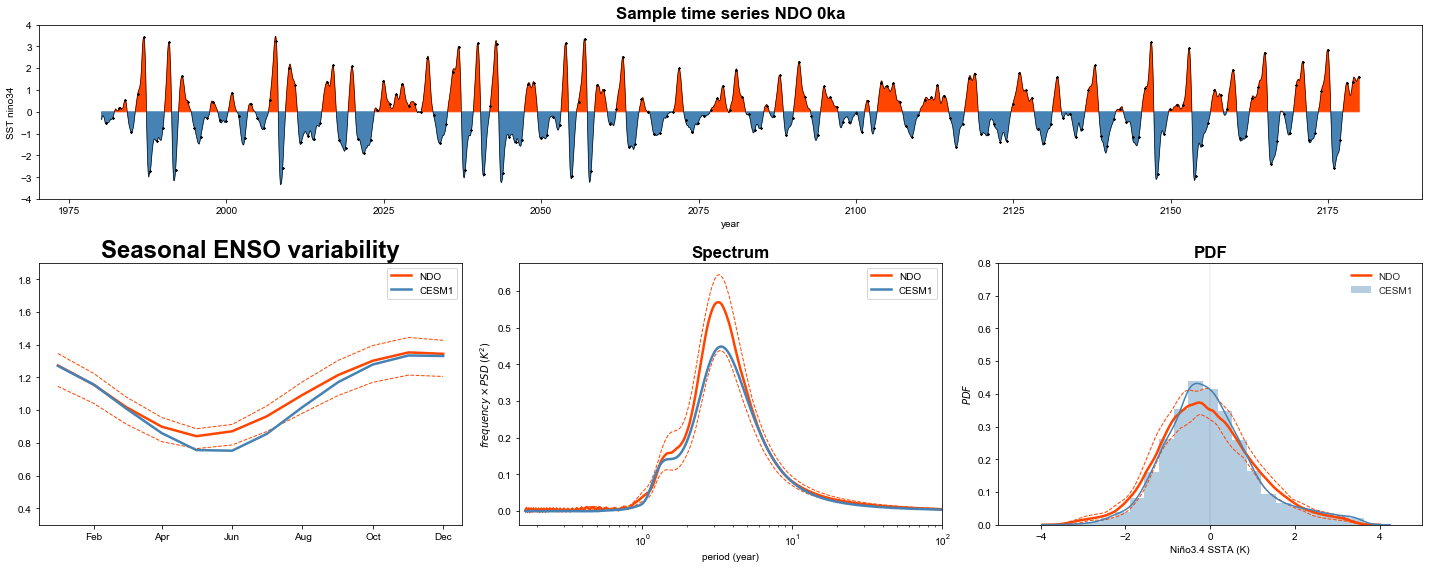

In [16]:
fig=plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(2, 3,height_ratios=[1, 1.5])

# 5 month running mean 
T_ndo=T_ndo[~np.isnan(np.nanmean(T_ndo,axis=1)),:]
nmember=nm=len(np.squeeze(np.where(~np.isnan(np.nanmean(T_ndo,axis=1)) == True)))
T_ndo_smooth=pd.rolling_mean(T_ndo, 5,center=True,axis=1)


# ----------------------   First plot time_series ----------------------
ax1 = plt.subplot(gs[0:3])


# nb years to display 
nyr_plot=200

# We pick one member to plot
T_plot=T_ndo_smooth[0,:].squeeze()  

# creation time axis 
ti=np.linspace(0,nyr_plot-1/12,len(T_plot[0:nyr_plot*12]))

ax1.plot((ti+1980),T_plot[0:nyr_plot*12],color='k',linewidth=0.59)
ax1.plot((ti+1980)[11::12],T_plot[0:nyr_plot*12][11::12],color='k',marker='*',linewidth=0,markersize=2)
ax1.fill_between(ti+1980,T_plot[0:nyr_plot*12],where=T_plot[0:nyr_plot*12] >= 0,color='orangered')
ax1.fill_between(ti+1980,T_plot[0:nyr_plot*12],where=T_plot[0:nyr_plot*12] <= 0,color='steelblue')
ax1.set_ylim(-4,4)
ax1.set_xlabel('year')
ax1.set_ylabel('SST nino34')
ax1.set_title('Sample time series NDO '+CASE, fontsize='17',weight='semibold')

# -------------------   Seasonal ENSO variability  ---------------------
ax2 = plt.subplot(gs[3])

# creation time axis 
xmonth= [datetime(2018, i+1, 1) for i in range(12)]

# Compute the std.dev of CESM1 Niño3.4 for each calendar month
seas_std_cesm     = [np.std(heat_budget['tos'][i::12]) for i in range(12)]

# Compute the std.dev of each NDO member for each calendar month 
seas_std_ndo=np.zeros((nmember,12))
for member in range(nmember): 
    seas_std_ndo[member,:] = [np.nanstd(T_ndo_smooth[member,:][i::12]) for i in range(12)]

seas_std_ndo_per=np.percentile(seas_std_ndo, (1,50,99), axis=0)
ax2.plot(xmonth,seas_std_ndo_per[1,:],color='orangered',label='NDO',linewidth=2.5)
ax2.plot(xmonth,seas_std_ndo_per[0,:],color='orangered',linestyle='--',linewidth=1)
ax2.plot(xmonth,seas_std_ndo_per[2,:],color='orangered',linestyle='--',linewidth=1)
ax2.plot(xmonth,seas_std_cesm,label='CESM1',color='steelblue',linewidth=2.5)

fmt=mdates.DateFormatter('%b')
ax2.xaxis.set_major_formatter(fmt)
ax2.set_title('Seasonal ENSO variability', fontsize='24',weight='semibold')
ax2.set_ylim(0.3,1.9)
ax2.legend()


# ----------------------------   Spectrum   ----------------------------
ax3 = plt.subplot(gs[4])

psd_cesm = CORRELOGRAMPSD(heat_budget['tos'], heat_budget['tos'], lag=12*5)
f_cesm = np.linspace(-0.5, 0.5, len(psd_cesm))
psd_cesm = cshift(psd_cesm, len(psd_cesm)/2)[f_cesm >0]

for member in range(nmember): 
    psd_ndo1 = CORRELOGRAMPSD(T_ndo[member,:],T_ndo[member,:], lag=12*5)
    if member == 0:
        f_ndo = np.linspace(-0.5, 0.5, len(psd_ndo1))  
        psd_ndo=np.zeros((nmember,int(len(psd_ndo1)/2)))
        
    psd_ndo[member,:] = cshift(psd_ndo1, len(psd_ndo1)/2)[f_ndo >0]

psd_ndo_per=np.nanpercentile(psd_ndo, (1,50,99), axis=0)
   
ax3.semilogx(1./f_ndo[f_ndo >0]/12, psd_ndo_per[1,:]*f_ndo[f_ndo >0],c='orangered',linewidth=2.5,label='NDO')
ax3.semilogx(1./f_ndo[f_ndo >0]/12, psd_ndo_per[0,:]*f_ndo[f_ndo >0],c='orangered',linewidth=1,linestyle='--')
ax3.semilogx(1./f_ndo[f_ndo >0]/12, psd_ndo_per[2,:]*f_ndo[f_ndo >0],c='orangered',linewidth=1,linestyle='--')
ax3.semilogx(1./f_cesm[f_cesm >0]/12, psd_cesm*f_cesm[f_cesm >0],label='CESM1',c='steelblue',linewidth=2.5)

ax3.set_xlim(0.15,100)
ax3.set_xlabel('period (year)')
ax3.set_ylabel(r'$frequency \times PSD \; (K^{2})$')

ax3.legend()
ax3.set_title('Spectrum', fontsize='17',weight='semibold')


# ----------------------------   Distribution   ----------------------------
ax4 = plt.subplot(gs[5])

sns.set_style("white")
bins=np.linspace(-5,5,30)


dist_ndo=np.zeros((nmember,len(bins)))
for member in range(nmember): 
    
    dist=sns.distplot(T_ndo_smooth[member,:],bins=np.linspace(-5,5,30),hist=False,kde_kws={'alpha': 0},ax=ax4).get_lines()[member].get_data()
    if member == 0: 
        dist_ndo =np.zeros((nmember,len(dist[0])))
    dist_ndo[member,:]=dist[1]

dist_ndo_per=np.percentile(dist_ndo, (1,50,99), axis=0)
ax4.plot(dist[0],dist_ndo_per[1,:],color='orangered',linewidth=2.5,label='NDO')
ax4.plot(dist[0],dist_ndo_per[0,:],color='orangered',linewidth=1,linestyle='--')
ax4.plot(dist[0],dist_ndo_per[2,:],color='orangered',linewidth=1,linestyle='--')
ax4.plot([0,0],[0,1],color='k',linewidth=0.1)
sns.distplot(heat_budget['tos'], hist=True,kde=True,hist_kws={'alpha': 0.4},label='CESM1',norm_hist=True,bins=bins,ax=ax4,color='steelblue')

ax4.set_title('PDF', fontsize='17',weight='semibold')
ax4.set_xlim(-5,5)
ax4.set_ylim(0,0.8)
ax4.set_xlabel('Niño3.4 SSTA (K)')
ax4.set_ylabel(r'$PDF$')

ax4.legend()

plt.tight_layout()
plt.show()

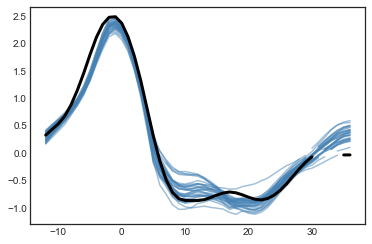

In [17]:
lag=np.linspace(-12,36,37+12)
ind_nino_cesm=np.squeeze(np.where(heat_budget['tos'][11::12] > 1.33))
ind_nino_cesm=(ind_nino_cesm+1)*12
nino_cesm=composite(heat_budget['tos'],ind_nino_cesm,0.05,lag=lag)

for i in range(nmember):
    ind_nino=np.squeeze(np.where(T_ndo[i,11::12] > 1.33))
    ind_nino=(ind_nino+1)*12
    nino_ndo=composite(T_ndo[i,:],ind_nino,0.05,lag=lag)

    plt.plot(lag,nino_ndo,color='steelblue',alpha=0.5)
    
plt.plot(lag,nino_cesm,color='k',linewidth=3)
plt.show()

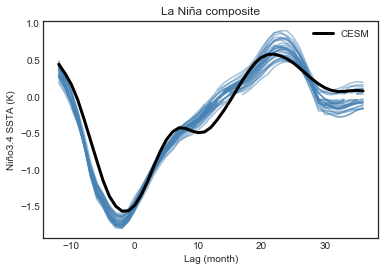

In [18]:
from matplotlib.pyplot import subplots, show
fig, ax = subplots()

lag=np.linspace(-12,36,37+12)
ind_nino_cesm=np.squeeze(np.where(heat_budget['tos'][11::12] < -1))
ind_nino_cesm=(ind_nino_cesm+1)*12
nino_cesm=composite(heat_budget['tos'],ind_nino_cesm,0.1,lag=lag)

for i in range(nmember):
    ind_nino=np.squeeze(np.where(T_ndo[i,11::12] < -1))
    ind_nino=(ind_nino+1)*12
    nino_ndo=composite(T_ndo[i,:],ind_nino,0.1,lag=lag)

    ax.plot(lag,nino_ndo,color='steelblue',alpha=0.5)
    
ax.plot(lag,nino_cesm,color='k',linewidth=3, label='CESM')
ax.legend()
ax.set_xlabel('Lag (month)')
ax.set_ylabel('Niño3.4 SSTA (K)')
ax.set_title('La Niña composite')
plt.show()


In [19]:
np.nanmean(T_ndo,axis=1)

array([-0.087261  , -0.07875058, -0.06500104, -0.0522404 , -0.0322073 ,
       -0.06742851, -0.06068665, -0.05359438, -0.06215088, -0.05419786,
       -0.07571894, -0.0879341 , -0.0350928 , -0.0408733 , -0.02144756,
       -0.06327858, -0.02823576, -0.01092173, -0.04218939, -0.10893062,
       -0.0886845 , -0.08066993, -0.04367185, -0.0828672 , -0.06576233,
       -0.05740518, -0.02720571, -0.04648843, -0.03967903, -0.03857283])

Text(0.5,1,'Sample time series NDO 0ka')

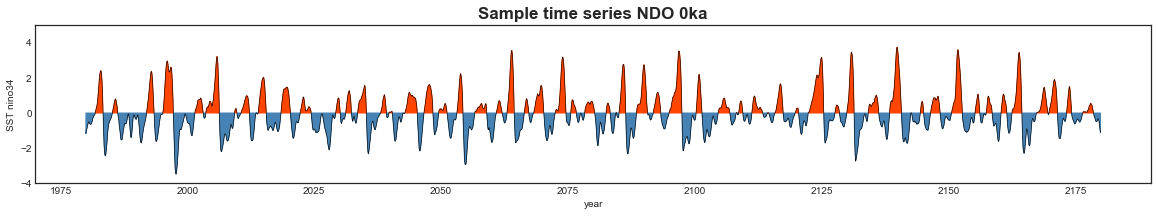

In [20]:
fig=plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(2, 3,height_ratios=[1, 1.5])

# ----------------------   First plot time_series ----------------------
ax1 = plt.subplot(gs[0:3])


# nb years to display 
nyr_plot=200

# We pick one member to plot
T_plot=heat_budget['tos'] 

# creation time axis 
ti=np.linspace(0,nyr_plot-1/12,len(T_plot[0:nyr_plot*12]))

ax1.plot((ti+1980),T_plot[0:nyr_plot*12],color='k',linewidth=0.59)
ax1.fill_between(ti+1980,T_plot[0:nyr_plot*12],where=T_plot[0:nyr_plot*12] >= 0,color='orangered')
ax1.fill_between(ti+1980,T_plot[0:nyr_plot*12],where=T_plot[0:nyr_plot*12] <= 0,color='steelblue')
ax1.set_ylim(-4,5)
ax1.set_xlabel('year')
ax1.set_ylabel('SST nino34')
ax1.set_title('Sample time series NDO '+CASE, fontsize='17',weight='semibold')

In [21]:
from scipy.signal import correlate
a_sig=heat_budget['tos']
b_sig=heat_budget['ztc']

lag = np.argmax(correlate(a_sig, b_sig))
c_sig = np.roll(b_sig, shift=int(np.ceil(lag)))

lag

7209

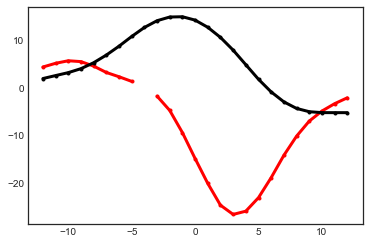

In [22]:
# plt.plot(heat_budget['ztc'][20:50],marker='.')
# plt.plot(heat_budget['tos'][20:50]*6,marker='.')

lag=np.linspace(-12,12,24+1)
ind_nino_cesm=np.squeeze(np.where(heat_budget['tos'][11::12] > 1.33))
ind_nino_cesm=(ind_nino_cesm+1)*12
nino_cesm=composite(heat_budget['tos'],ind_nino_cesm,0.05,lag=lag)
nino_cesm2=composite(heat_budget['ztc'],ind_nino_cesm,0.05,lag=lag)


plt.plot(lag,nino_cesm2,color='r',linewidth=3,marker='.')


plt.plot(lag,nino_cesm*6,color='k',linewidth=3,marker='.')
plt.show()



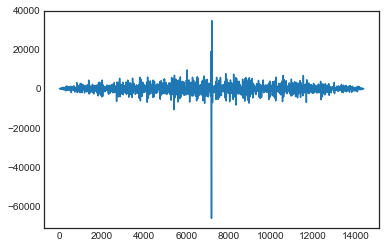

In [23]:
plt.plot(correlate(a_sig, b_sig))

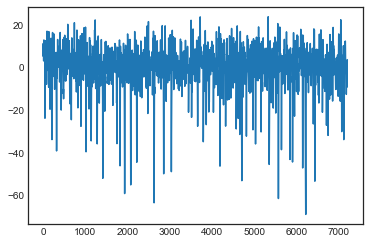

In [24]:
plt.plot(c_sig)

11

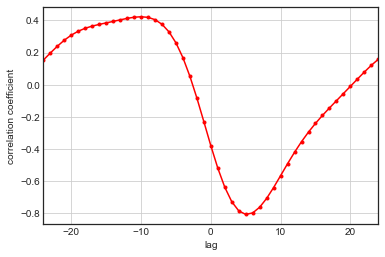

In [25]:
nx = len(heat_budget['tos'])
lags = np.arange(-nx + 1, nx) # so last value is nx - 1

# Remove sample mean.

autocorr_xdm = np.correlate(heat_budget['ztc'],heat_budget['tos'], mode='full')
# Normalize by the zero-lag value:
autocorr_xdm /= nx*(np.std(heat_budget['tos'])*np.std(heat_budget['ztc']))

fig, ax = plt.subplots()
ax.plot(lags, autocorr_xdm, 'r',marker='.')
ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.grid(True)
ax.set_xlim(-24,24)

nx-np.argmax(autocorr_xdm)

In [37]:
from IPython.display import display, HTML

js = """ <script type='text/javascript' src='https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js'></script> """ 
display(HTML(js))